# "Spam or Ham" with Support Vector Machines

## Introduction 

This Jupyter notebook contains an implementation of a binary text classifier with SVMs to separate email-SPAM from email-HAM.
The global SPAM volume as percentage of total email traffic is estimated to be somewhere between 60% and 80%. Since for most people email-SPAM is a rather unpleasant experience, various anti-SPAM techniques evolved. Content based filtering system is one of them. Such a filter can be achieved using a binary classifier (in this case SVM) for the two classes "HAM" and "SPAM".

In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

def plot_svm(X, Y, clf):
    w = clf.coef_[0]
    b = clf.intercept_
    xx = np.linspace(min(X[:,0]), max(X[:,0]))
    yy = (- b - w[0] * xx) / w[1]

    margin = 1 / np.linalg.norm(w)

    plt.figure(figsize=(10, 10))
    plt.clf()
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy - margin, 'k--', color="blue")
    plt.plot(xx, yy + margin, 'k--', color="red")

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
                edgecolors='k')

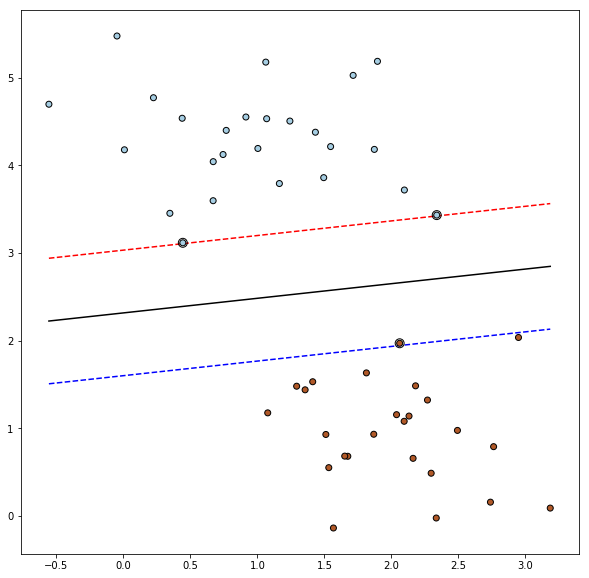

In [2]:
# linear kernel svm
X, Y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
clf = SVC(kernel='linear')
clf.fit(X, Y)
plot_svm(X, Y, clf)

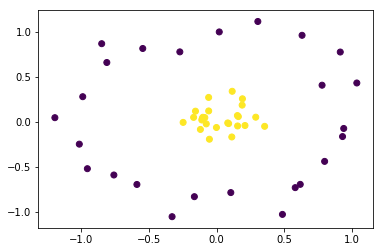

In [3]:
from sklearn.datasets.samples_generator import make_circles

# non-linear data
X, Y = make_circles(50, factor=.1, noise=.1)
plt.scatter(X[:,0], X[:, 1], c=Y)

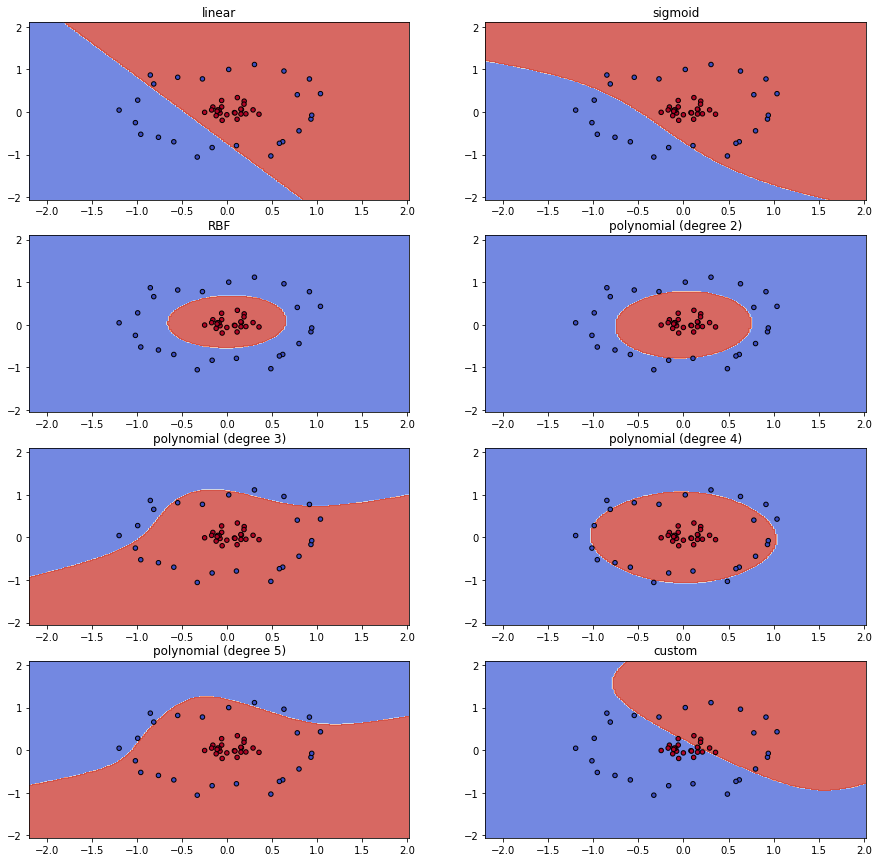

In [4]:
"""
 SVM kernels example on linear data.
"""

# function from: http://scikit-learn.org 
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

# function from http://scikit-learn.org
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

C = 1.0

def my_kernel(X, Y):
    return np.dot(np.sin(X), np.cos(Y.T))

models = ((SVC(kernel='linear', C=C), "linear"), 
          (SVC(kernel="sigmoid", C=C), "sigmoid"),
          (SVC(kernel='rbf', gamma=0.7, C=C), "RBF"),
          (SVC(kernel='poly', degree=2, C=C), "polynomial (degree 2)"),
          (SVC(kernel='poly', degree=3, C=C), "polynomial (degree 3)"),
          (SVC(kernel='poly', degree=4, C=C), "polynomial (degree 4)"),
          (SVC(kernel='poly', degree=5, C=C), "polynomial (degree 5)"),
          (SVC(kernel=my_kernel), "custom"))
models = [(clf.fit(X, Y), title) for clf, title in models]

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, sub = plt.subplots((len(models) + 1) // 2, 2, figsize=(15,15))
for (clf, title), ax in zip(models, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_title(title)

## SPAM | HAM Data

This folder contains a collection of ~60k labeled emails from various sources. The following code loads the email-bodies into a pandas dataframe.

In [5]:
import os
import re
from pandas import DataFrame

def get_files(path):
    return [os.path.join(root, file) for root, _, files in os.walk(path) for file in files]

def read_file(path):
    with open(path, "r", encoding="latin-1") as file:
        lines = file.readlines()
    try:
        idx = lines.index("\n")
    except ValueError as e:
        header, body = lines, []
    else:
        header, body = lines[:idx], lines[idx:]
    return " ".join(body)

HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('data/spam',        SPAM),
    ('data/easy_ham',    HAM),
    ('data/hard_ham',    HAM),
    ('data/beck-s',      HAM),
    ('data/farmer-d',    HAM),
    ('data/kaminski-v',  HAM),
    ('data/kitchen-l',   HAM),
    ('data/lokay-m',     HAM),
    ('data/williams-w3', HAM),
    ('data/BG',          SPAM),
    ('data/GP',          SPAM),
    ('data/SH',          SPAM)
]
def build_data_frame(sources):
    files = [(read_file(file), cat) for path, cat in sources for file in get_files(path)]
    return DataFrame(files, columns=["text", "class"])

In [6]:
# data frame with the email bodies
df = build_data_frame(SOURCES)

In [7]:
df.head()

text class
0                                                     spam
1  \n Greetings!\n \n You are receiving this lett...  spam
2  \n <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0...  spam
3  \n <html>\n <body>\n <center>\n <h3>\n <font c...  spam
4  \n 1) Fight The Risk of Cancer!\n http://www.a...  spam

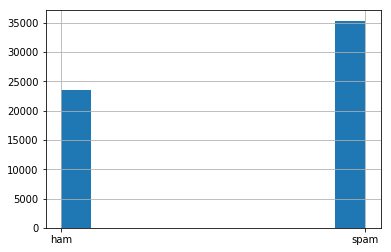

In [8]:
df["class"].hist()

## Preprocessing and Feature encoding
First of all you need to encode your emails such that the SVM can deal with it. In general this problem is called feature encoding. In this case we need some kind of word embedding:
> Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing (NLP) where words or phrases from the vocabulary are mapped to vectors of real numbers. [wikipedia](https://en.wikipedia.org/wiki/Email_filtering)

Pupular techniques are "word2vec" or ["bag-of-words"](https://en.wikipedia.org/wiki/Bag-of-words_model). As an example for a binary "bag-of-words" model, consider the following two sentences:
> "This is the first sentence and the bla"

> "This is another bunch of words"

From these sentences we can construct a vocabulary corpus:
    
    ["This" "is" "the" "first" "sentence" "another" "bunch" "of" "words" "and" "bla"]

Here, the corpus items represent the features, counting 11 in total.

We now check for each sentence, whether the items of the corpus exist or not:
For the first sentence we get:

    [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]

For the second sentence we get:
    
    [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]

We don't care about the position of the word in the sentences or multiple occurrences. Obviously there are more sophisticated language models.

In [9]:
# enron ergänzt (ist der Name eines Datensatzes?)
stopwords = {'enron', 'the', 'ourselves', 'hers', 'between', 'yourself', 'but',
             'again', 'there', 'about', 'once', 'during', 'out',
             'very', 'having', 'with', 'they', 'own', 'an', 'be',
             'some', 'for', 'do', 'its', 'yours', 'such', 'into',
             'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am',
             'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves',
             'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through',
             'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down',
             'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours',
             'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same',
             'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that',
             'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he',
             'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those',
             'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by',
             'doing', 'it', 'how', 'further', 'was', 'here', 'than'} 

In [10]:
### Bereinigung der Email-Texte
# --> Datensatz wird so bearbeitet, dass alle Emails nur noch Wörter enthalten und durch split() aufgeteilt werden können

from bs4 import BeautifulSoup
import re

# BeautifulSoup ist ein Tool um HTML zu bearbeiten --> Ermöglicht das entfernen aller HTML-Codes
def strip_html(input):
    return BeautifulSoup(input, "lxml").text

def strip_token(input):
    r = re.compile(r"[^a-zA-Z0-9 ]")
    return r.sub(" ",input)

def strip_singleCharacters(input):
    r = re.compile(r"\b[a-z]\b")
    return r.sub(" ",input)

def strip_standaloneNumbers(input):
    r = re.compile(r"\b[0-9]+\b")
    return r.sub(" ",input)

def strip_multipleSpaces(input):
    r = re.compile(r" +")
    return r.sub(" ",input)

def strip_all(input):
    return strip_multipleSpaces(strip_standaloneNumbers(strip_singleCharacters(strip_token(strip_html(input.lower())))).strip(" "))

df.text = [strip_all(text) for text in df.text]

In [14]:
### Erstellen des Wörterbuchs aller Trainingsemails

from collections import Counter

corpus = [w for text in df_small.text for w in text.split(" ") if w not in stopwords]
words = Counter(corpus)

# Löschen seltener Wörter
for k in list(words):
    if words[k] < 3:
        del words[k]

print("{:<9}{:>8}".format("w", "freq(w)"), "\n", "-"*14)
for word, freq in words.most_common(10):
    print("{:<7}{:8d}".format(word, freq))
    

w         freq(w) 
 --------------
com       12415
http      10501
ect        8400
content    6778
www        6536
company    6456
please     5712
font       5133
new        4933
message    4519


In [17]:
# Funktion liefert das bag-of-words feature einer Email
def vectorize(words, text):
    textDict = Counter([w for w in text.split(" ")])
    return [word in textDict and 1 or 0 for word in words]

In [18]:
### Auswählen von 10000 Emails für das Training (jeweils 5000 spam und 5000 ham)
# --> Nicht der gesamte Datensatz, da sonst Speicherprobleme und Performanceprobleme auftreten

import pandas as pd

numSpam=5000
numHam=5000

df_small = pd.concat([df[df["class"] == "spam"].sample(numSpam), df[df["class"] == "ham"].sample(numHam)])

In [24]:
### Erstellen des Trainingsdatensatz X und des Lösungsvektors y

X = np.zeros((len(df_small.text), len(words.keys())))
y = np.zeros(len(df_small.text))

index = 0
for i,r in df_small.iterrows():                               # iterrows, da die Originale Indexierung durch sample() erhalten wurde
    X[index,:]=vectorize(words,df_small.text[i])
    y[index] = df_small["class"][i] == "spam" and 1 or 0      # 1 wenn spam, 0 wenn ham
    index = index + 1

In [25]:
### Auswählen von 200 Emails für den Test (jeweils 100 spam und 100 ham)
# --> Es werden nur Emails ausgewählt, die nicht zum Training benutzt wurden

numSpam_test=100
numHam_test=100

df_test_spam = df[~df.index.isin(df_small.index)][df["class"] == "spam"].sample(numSpam_test)
df_test_ham = df[~df.index.isin(df_small.index)][df["class"] == "ham"].sample(numHam_test)
df_test = pd.concat([df_test_spam, df_test_ham])

X_test = np.zeros((len(df_test.text), len(words.keys())))
y_test = np.zeros(len(df_test.text))

index = 0
for i,r in df_test.iterrows():
    X_test[index,:]=vectorize(words,df_test.text[i])
    y_test[index] = df_test["class"][i] == "spam" and 1 or 0
    index = index + 1

/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## Training the SVM  

- Train SVM models with various kernels.

In [26]:
from sklearn.metrics import accuracy_score
C=35 #scheint ein guter Wert zu sein --> könnte man noch ausführlich testen

In [27]:
#models = ((SVC(kernel='linear', C=C)), 
#          (SVC(kernel="sigmoid", C=C)),
#          (SVC(kernel='rbf', gamma=0.7, C=C)),
#          (SVC(kernel='poly', degree=2, C=C)),
#          (SVC(kernel='poly', degree=3, C=C)),
#          (SVC(kernel='poly', degree=4, C=C)),
#          (SVC(kernel='poly', degree=5, C=C)))
          
#fits = [clf.fit(X, y) for clf in models]
#predictions = [clf.predict(X_test) for clf in fits]
#accuracys = [accuracy_score(y_test,y_pred) for y_pred in predictions]
#accuracys

# --> linearer Kernel hier der beste

In [28]:
model=SVC(kernel='linear',C=C)
model.fit(X,y)
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)

print('accuracy:')
print(accuracy)
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
cm

accuracy:
0.97


array([[97,  3],
       [ 3, 97]])